In [1]:

import netCDF4 as nc
#import netcdftime as nctime
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob, sys, os
import csv
import pandas as pd

# ECP modules
import PlotTools.plot_tools as PT
import data_info_PALS as datainfo
from maths_tools import TimeSeriesTools as TST

plt.rcParams['figure.figsize']=(20,12)
%matplotlib inline



In [2]:
INTERACTIVE='Y'
iDISPLAY='Y'

########################################
# Constants and options
kgC_to_umolsCO2_factor = (1./12.)* 1e9
seconds_in_year = 60.*60.*24.*365.
Lc_H2O = 2.501e6
SITE_colour = 'red'
JULES_colour= 'green'

#LC_names = ['Broadleaf','Needleleaf','C3 grass','C4 Grass','shrub',\
#            'urban','lake','soil','ice']
LC_names = ['Tree','Tree','Grass','Grass','shrub',\
            'urban','lake','soil','ice']
nLCs = len(LC_names)
LC_markers = [ 'x','+','v','^','D',\
               's','p','o','h']
LC_mews    = [ 2,2,0,0,0,\
               0,0,0,0]
LC_symsizes= [ 80 for i in range(nLCs) ]
LC_handles = [ plt.Line2D((0,1),(0,0), color='k', marker=LC_markers[iLC], linestyle='') for iLC in range(nLCs) ]

SEAS_names=['DJF','MAM','JJA','SON']
nSEAS=4

J_soil_depths=np.array([0.1,0.25,0.65,2.0])
nsoillyrs=4

nbulklyrs=3
J_soil_weights=J_soil_depths[:nbulklyrs]/J_soil_depths[:nbulklyrs].sum()
#print(J_soil_weights)

###################################
# Directories and filenames
PALS_dir = '/prj/GREENHOUSE/PALS_comparison/'
site_metadata_file = PALS_dir+'sites_meta_plot.csv'
site_frac_file = PALS_dir+'sites_julesfracs.dat'
#
JULES_output_dir = PALS_dir+'output/'
#
SITE_data_dir = '/data/grp/fluxdata/PALS_sites_ECP/'
#
BASE_plot_dir = PALS_dir+'plots/'

###################################
# Read in meta data
meta_data=list(csv.reader(open(site_metadata_file,'r')))
meta_data_hdrs=meta_data.pop(0)

site_frac_dat = list(csv.reader(open(site_frac_file,'r'),delimiter='-'))
frac_list = [line[1][1:] for line in site_frac_dat]

###################################
# Fetch JULES sources info
JULES_sources = datainfo.JULES_sources()



In [3]:
################################################################################
# Select a site from the list of available sites
if (INTERACTIVE=='Y'):
    print('Available sites: ')
    print('%3s%15s%15s%10s%10s' % (' # ','Site','Country','latitude','longitude'))
    for i, site_meta in zip(range(len(meta_data)),meta_data):
        print( '%3s:%15s%15s%10s%10s' % (i, site_meta[0].strip(), \
                                            site_meta[1].strip(), \
                                            site_meta[7].strip(), \
                                            site_meta[8].strip()) )
    
    SITE = int(input('Enter flux site: '))
else:
    SITE=9
    
print('SITE = ',SITE,meta_data[SITE][0].strip())

Available sites: 
 #            Site        Country  latitude longitude
  0:        Amplero          Italy   41.9041   13.6052
  1:        Audubon  United States   31.5907   -110.51
  2:       Blodgett  United States   38.8952  -120.633
  3:          Bondv  United States   40.0062  -88.2904
  4:         Boreas         Canada   55.8796  -98.4808
  5:       Brooking  United States   44.3453  -96.8362
  6:          Bugac        Hungary   46.6911   19.6013
  7:         Cabauw    Netherlands    51.971     4.927
  8:         Castel          Italy   41.7052   12.3761
  9:         Degero         Sweden   64.1833     19.55
 10:        ElSaler          Spain    39.346  -0.31881
 11:        Espirra       Portugal   38.6394   -8.6018
 12:       FortPeck  United States   48.3077  -105.102
 13:        Goodwin  United States   34.2547  -89.8735
 14:        Harvard  United States   42.5378  -72.1715
 15:          Hesse         France   48.6742   7.06462
 16:       Howlandm  United States   45.2041  -6

In [4]:
print(INTERACTIVE)

Y


In [5]:
######################################################################################
# Select JULES source[s]
if (INTERACTIVE=='Y'):
    print('Available JULES sources: ')
    for i,Jsource in zip(range(len(JULES_sources)),JULES_sources):
        print('%3s:%25s' % (i,Jsource[0]) )

    source_temp = input('Enter JULES sources to plot sepeated by commas, '+\
                            'for all sources enter ALL: ')
    if source_temp=='ALL':
        J_SOURCES = range(len(JULES_sources))
    else:
        J_SOURCES = [int(source) for source in source_temp.split(',')]

    del source_temp
else:
    J_SOURCES=[0,1]
    
nJSOURCES = len(J_SOURCES)
J_names = [JULES_sources[iSOURCE][1]['longname'] for iSOURCE in J_SOURCES]
print('nJSOURCES, J_SOURCES = ',nJSOURCES,J_names)

# construct list of inputs required for plotting later:
PS_names  = [ 'Site' ] + J_names 
PS_colours = [ SITE_colour ] + [JULES_sources[iSOURCE][1]['colour'] for iSOURCE in J_SOURCES]
nPS = len(PS_names)
PS_handles = [plt.Line2D((0,1),(0,0),color=PS_colours[iPS],lw=3) for iPS in range(nPS)] 


Available JULES sources: 
  0:                   Jvn4.5
  1:         Jvn4.5_notriffid
  2:     Jvn4.5_notriffid_mod
  3:            Jvn4.5_noT_TP
  4:       Jvn4.5_noT_TP_lev2
  5:                 Jvn4.3.1
  6:               Jvn4.3.1-E
  7:          Jvn4.3.1-E-preN
  8:             Jvn4.3.1-E-F
  9:        Jvn4.3.1-E-F-preN
 10:      Jvn4.3.1-E-F_repara
 11:         Jvn4.3.1-E-F-DOC
 12:        Jvn4.3.1-E-F-varN
 13: Jvn4.3.1-E-F-repara-varN
 14:        Jvn4.3.1-E-F-lowN
Enter JULES sources to plot sepeated by commas, for all sources enter ALL: 0,3
nJSOURCES, J_SOURCES =  2 ['Jv4.5', 'Jv4.5_noT_TP']


In [6]:

#######################################################################################
# T resolution
Tres_names = ['tstep','day']
Tres_Stags = ['','_daily']
if INTERACTIVE=='Y':
    print('Available time resolutions: ')
    for iTRES in range(len(Tres_names)):
        print( iTRES, '- '+Tres_names[iTRES])
    iTRES = int(input('Select a time resolution: '))
else:
    iTRES = 1

Tres = Tres_names[iTRES]
Tres_Stag= Tres_Stags[iTRES]



Available time resolutions: 
0 - tstep
1 - day
Select a time resolution: 1


In [7]:
# Optional plot_dir input
plot_dir=BASE_plot_dir+'temp/'
if (INTERACTIVE=='Y'):
    print('Plot output directory: '+plot_dir)
    plot_dir_temp=input('Enter alternative plot output directory or hit return to continue: ')
    if (len(plot_dir_temp)>0):
        plot_dir=plot_dir_temp
        
        

Plot output directory: /prj/GREENHOUSE/PALS_comparison/plots/temp/
Enter alternative plot output directory or hit return to continue: 


In [8]:
temp_frac = frac_list[SITE].split()
site_meta=meta_data[SITE]
frac=np.array(temp_frac,dtype='float')
site_name=site_meta[0].strip()
site_country=site_meta[1].strip()
site_vegtype=site_meta[2].strip()
site_canht=site_meta[3].strip()
site_measht=site_meta[4].strip()
site_lat=site_meta[7].strip()
site_lon=site_meta[8].strip()

site_pft=temp_frac.index(max(temp_frac))
site_marker=LC_markers[temp_frac.index(max(temp_frac))]

site_plot_dir = plot_dir+site_name+'/'
os.system('mkdir -p '+site_plot_dir)

print('Site: '+site_name)
print('Plots saved in: '+site_plot_dir)


Site: Blodgett
Plots saved in: /prj/GREENHOUSE/PALS_comparison/plots/temp/Blodgett/


In [9]:
######################################
# Read in-situ site data
SITE_fname = SITE_data_dir+site_name+'Fluxnet.1.4_flux'+Tres_Stag+'.nc'
print(SITE_fname)
Sinf       = nc.Dataset(SITE_fname,'r')
############################################################
# Extract data and convert to same units (Site data units)
#'time':nctime.num2date(Sinf.variables['time'][:],units=Sinf.variables['time'].units),       \
S_data = {'NEE':Sinf.variables['NEE'][:].squeeze()*-1.0,                    \
          'TER':Sinf.variables['TER'][:].squeeze(), \
          'GPP':Sinf.variables['GPP'][:].squeeze(), \
          'LHF':Sinf.variables['Qle'][:].squeeze(),                         \
          'SHF':Sinf.variables['Qh'][:].squeeze(),                          \
          }

#         'TER':np.ma.masked_less(Sinf.variables['TER'][:].squeeze(),0.0), \
#         'GPP':np.ma.masked_less(Sinf.variables['GPP'][:].squeeze(),0.0), \

S_seconds=Sinf.variables['time'][:].astype('float64')
S_seconds=np.round(S_seconds/1800.)*1800.
S_time = nc.num2date(S_seconds, \
                         units=Sinf.variables['time'].units)
S_data['FQW'] = S_data['LHF']/Lc_H2O
S_data['WUE'] = S_data['GPP']/S_data['FQW']
    
S_panda = pd.DataFrame( S_data, index=S_time )

# Store Annual C uptake in a list for later plots
SITE_Net_Annual_Evap=S_panda['FQW'].mean()*seconds_in_year
SITE_Net_Annual_Heat=S_panda['SHF'].mean()*seconds_in_year
SITE_Net_Annual_Cuptake=(S_panda['NEE'].mean()/kgC_to_umolsCO2_factor)\
                         * seconds_in_year
SITE_Gross_Annual_Cuptake=(S_panda['GPP'].mean()/kgC_to_umolsCO2_factor)\
                           * seconds_in_year
Sinf.close()


/data/grp/fluxdata/PALS_sites_ECP/BlodgettFluxnet.1.4_flux_daily.nc


In [10]:
print(SITE_Net_Annual_Cuptake)


0.625634891579


In [12]:
############################################
# Loop round JULES sources and extract data to dictionary of lists
J_pandas=[]
J_soil_pandas=[]

JULES_Net_Annual_Evap = []
JULES_Net_Annual_Heat = []
JULES_Net_Annual_Cuptake = []
JULES_Gross_Annual_Cuptake = []
JULES_mean_diurnal_GPP_Amplitude = [] 
JULES_mean_diurnal_NEE_Amplitude = [] 
JULES_mean_diurnal_GPP_Amplitude_BySeas = [ [] for j in range(4) ]
JULES_mean_diurnal_NEE_Amplitude_BySeas = [ [] for j in range(4) ]

# Correlations and standard deviations for taylor plots
SHF_correlation = []
SHF_meanbias    = []
SHF_stddev      = []
LHF_correlation = []
LHF_meanbias    = []
LHF_stddev      = []
NEE_correlation = []
NEE_meanbias    = []
NEE_stddev      = []
GPP_correlation = []
GPP_meanbias    = []
GPP_stddev      = []

for Jcnt in range(nJSOURCES):
    iSOURCE = J_SOURCES[Jcnt]
    #print iSOURCE, Jcnt, len(JULES_sources), nJSOURCES
    Jsource = JULES_sources[iSOURCE]
    ######################################
    # Construct filename and open:
    JULES_fname=Jsource[1]['data_dir']+site_name+'.'+Tres+'.nc'
    print(JULES_fname)
    Jinf = nc.Dataset(JULES_fname,'r')
    
    J_tsoil=Jinf.variables['t_soil'][:].squeeze()
    J_smcl=Jinf.variables['smcl'][:].squeeze()/J_soil_depths
    J_sthu=Jinf.variables['sthu'][:].squeeze()
    J_soil_data = {'t_soil':J_tsoil.flatten(),  \
                   'smcl':J_smcl.flatten(),      \
                   'sthu':J_sthu.flatten(),    \
                  }    
    
    J_data = { 'NPP':Jinf.variables[Jsource[1]['npp_name']][:].squeeze() \
                                *   kgC_to_umolsCO2_factor,              \
               'GPP':np.ma.masked_less(Jinf.variables[Jsource[1]['gpp_name']][:].squeeze() \
                                *   kgC_to_umolsCO2_factor, 1e-5 ),               \
               'resp_s':Jinf.variables[Jsource[1]['resp_s_name']][:].squeeze() \
                                *   kgC_to_umolsCO2_factor,                   \
               'resp_p':Jinf.variables[Jsource[1]['resp_p_name']][:].squeeze() \
                                *   kgC_to_umolsCO2_factor,                   \
              'FQW':Jinf.variables['fqw_gb'][:].squeeze(),                 \
              'LHF':Jinf.variables['latent_heat'][:].squeeze(),            \
              'SHF':Jinf.variables['ftl_gb'][:].squeeze(),                 \
              't_soil_bulk':(J_tsoil[:,:nbulklyrs]*J_soil_weights[:nbulklyrs]).sum(axis=1), \
              'sthu_bulk':(J_sthu[:,:nbulklyrs]*J_soil_weights[:nbulklyrs]).sum(axis=1), \
              'smcl_bulk':(J_smcl[:,:nbulklyrs]*J_soil_weights[:nbulklyrs]).sum(axis=1), \
              'precip':Jinf.variables['precip'][:].squeeze(),              \
              'sw_down':Jinf.variables['sw_down'][:].squeeze(),            \
              'tair':Jinf.variables['tl1'][:].squeeze(),                   \
              'SpecHum':Jinf.variables['qw1'][:].squeeze(),                \
              #'runoff':Jinf.variables['runoff'][:].squeeze(),              \
              #'SUBroff':Jinf.variables['sub_surf_roff'][:].squeeze(),      \
              #'SURFroff':Jinf.variables['surf_roff'][:].squeeze(),         \
              #'FSMC':Jinf.variables['fsmc'][:,1,:].squeeze(),  \
              }
    
    # Quick fix to add diurnal cycle to J-E-F output
    if (Tres=='tstep') & ('-E-' in Jsource[1]['longname']):
        print('Calculating Diurnal NPP from original NPP and the ratio of '+\
              ' npp_nuptake_out/npp_nuptake_out')
        J_data['NPP']= Jinf.variables['npp_gb'][:].squeeze() * \
                     ( Jinf.variables['npp_nuptake_out_gb'][:].squeeze() / \
                       Jinf.variables['npp_nuptake_in_gb'][:].squeeze()  ) \
                      *   kgC_to_umolsCO2_factor
        
    J_data['NEE']= J_data['NPP']-J_data['resp_s'] 
    J_data['WUE']= J_data['GPP']/J_data['FQW']
    J_seconds=Jinf.variables['time_bounds'][:,0].astype('float64')
    J_seconds=np.round(J_seconds/1800.)*1800.
    J_time=nc.num2date(J_seconds, units=Jinf.variables['time'].units  )
    
    J_panda = pd.DataFrame(J_data,index=J_time)
    J_pandas.append(J_panda.copy())
    
    J_soil_index = [ np.array([[ts,ts,ts,ts] for ts in J_time]).flatten(), \
                     np.array([J_soil_depths for i in range(len(J_time))]).flatten() \
                   ]
    # np.array([ ['0.10','0.25','0.65','2.0'] for i in range(len(J_time))]).flatten() \
    J_soil_Mindex = pd.MultiIndex.from_arrays( J_soil_index, names=['time','depth'] )

    J_soil_panda = pd.DataFrame(J_soil_data,index=J_soil_Mindex)
    J_soil_pandas.append(J_soil_panda.copy())
    
    Jinf.close()
    
    # Calculate Annual uptakes/evaporation/energ flux
    JULES_Net_Annual_Evap.append( J_panda['FQW'].mean()*seconds_in_year )
    JULES_Net_Annual_Heat.append( J_panda['SHF'].mean()*seconds_in_year )
    
    JULES_Net_Annual_Cuptake.append(J_panda['NEE'].mean()*   \
                                    seconds_in_year/kgC_to_umolsCO2_factor )
    
    JULES_Gross_Annual_Cuptake.append(J_panda['GPP'].mean()* \
                                      seconds_in_year/kgC_to_umolsCO2_factor )
    
    # Calculate and store the Specific Heat Flux Statistics  
    SHF_meanbias.append((J_panda['SHF']-S_panda['SHF']).mean()) 
    SHF_stddev.append( (J_panda['SHF']-S_panda['SHF']).std() )
    SHF_correlation.append( J_panda['SHF'].corr(S_panda['SHF']))
    
    # Calculate and store the Latent Heat Flux Statistics  
    LHF_meanbias.append((J_panda['LHF']-S_panda['LHF']).mean()) 
    LHF_stddev.append( (J_panda['LHF']-S_panda['LHF']).std() )
    LHF_correlation.append( J_panda['LHF'].corr(S_panda['LHF']))
    
    # Calculate and store the NEE Statistics  
    NEE_meanbias.append((J_panda['NEE']-S_panda['NEE']).mean()) 
    NEE_stddev.append( (J_panda['NEE']-S_panda['NEE']).std() )
    NEE_correlation.append( J_panda['NEE'].corr(S_panda['NEE']))
    
    # Calculate and store the GPP Statistics  
    GPP_meanbias.append((J_panda['GPP']-S_panda['GPP']).mean()) 
    GPP_stddev.append( (J_panda['GPP']-S_panda['GPP']).std() )
    GPP_correlation.append( J_panda['GPP'].corr(S_panda['GPP']))
    
print('Net C Annual Uptake = ',JULES_Net_Annual_Cuptake)

/prj/GREENHOUSE/PALS_comparison/Jvn4.5/output/Blodgett.day.nc
/prj/GREENHOUSE/PALS_comparison/Jvn4.5_noT_TP/output/Blodgett.day.nc
Net C Annual Uptake =  [-0.1006183417339325, 0.031948837710857395]


In [13]:
J_soil_data['t_soil'].shape


(10224,)

In [14]:

#Create Parameter Pandas
LHF_panda=pd.concat([S_panda['LHF']]+[J_panda['LHF'] for J_panda in J_pandas],axis=1)
LHF_panda.columns=[PS_names]
#LHF_panda=LHF_panda.dropna(0)
SHF_panda=pd.concat([S_panda['SHF']]+[J_panda['SHF'] for J_panda in J_pandas],axis=1)
SHF_panda.columns=(PS_names)
#SHF_panda=SHF_panda.dropna(0)
NEE_panda=pd.concat([S_panda['NEE']]+[J_panda['NEE'] for J_panda in J_pandas],axis=1)
NEE_panda.columns=(PS_names)
#NEE_panda=NEE_panda.dropna(0)
GPP_panda=pd.concat([S_panda['GPP']]+[J_panda['GPP'] for J_panda in J_pandas],axis=1)
GPP_panda.columns=(PS_names)
#GPP_panda=GPP_panda.dropna(0)
NPP_panda=pd.concat([J_panda['NPP'] for J_panda in J_pandas],axis=1)
NPP_panda.columns=(PS_names[1:])
#NPP_panda=NPP_panda.dropna(0)
RESPS_panda=pd.concat([J_panda['resp_s'] for J_panda in J_pandas],axis=1)
RESPS_panda.columns=(PS_names[1:])
#RESPS_panda=RESPS_panda.dropna(0)
RESPP_panda=pd.concat([J_panda['resp_p'] for J_panda in J_pandas],axis=1)
RESPP_panda.columns=(PS_names[1:])
#RESPP_panda=RESPP_panda.dropna(0)
TER_panda=pd.concat([S_panda['TER']]+[J_panda['resp_s']+J_panda['resp_p'] for J_panda in J_pandas],axis=1)
TER_panda.columns=(PS_names)



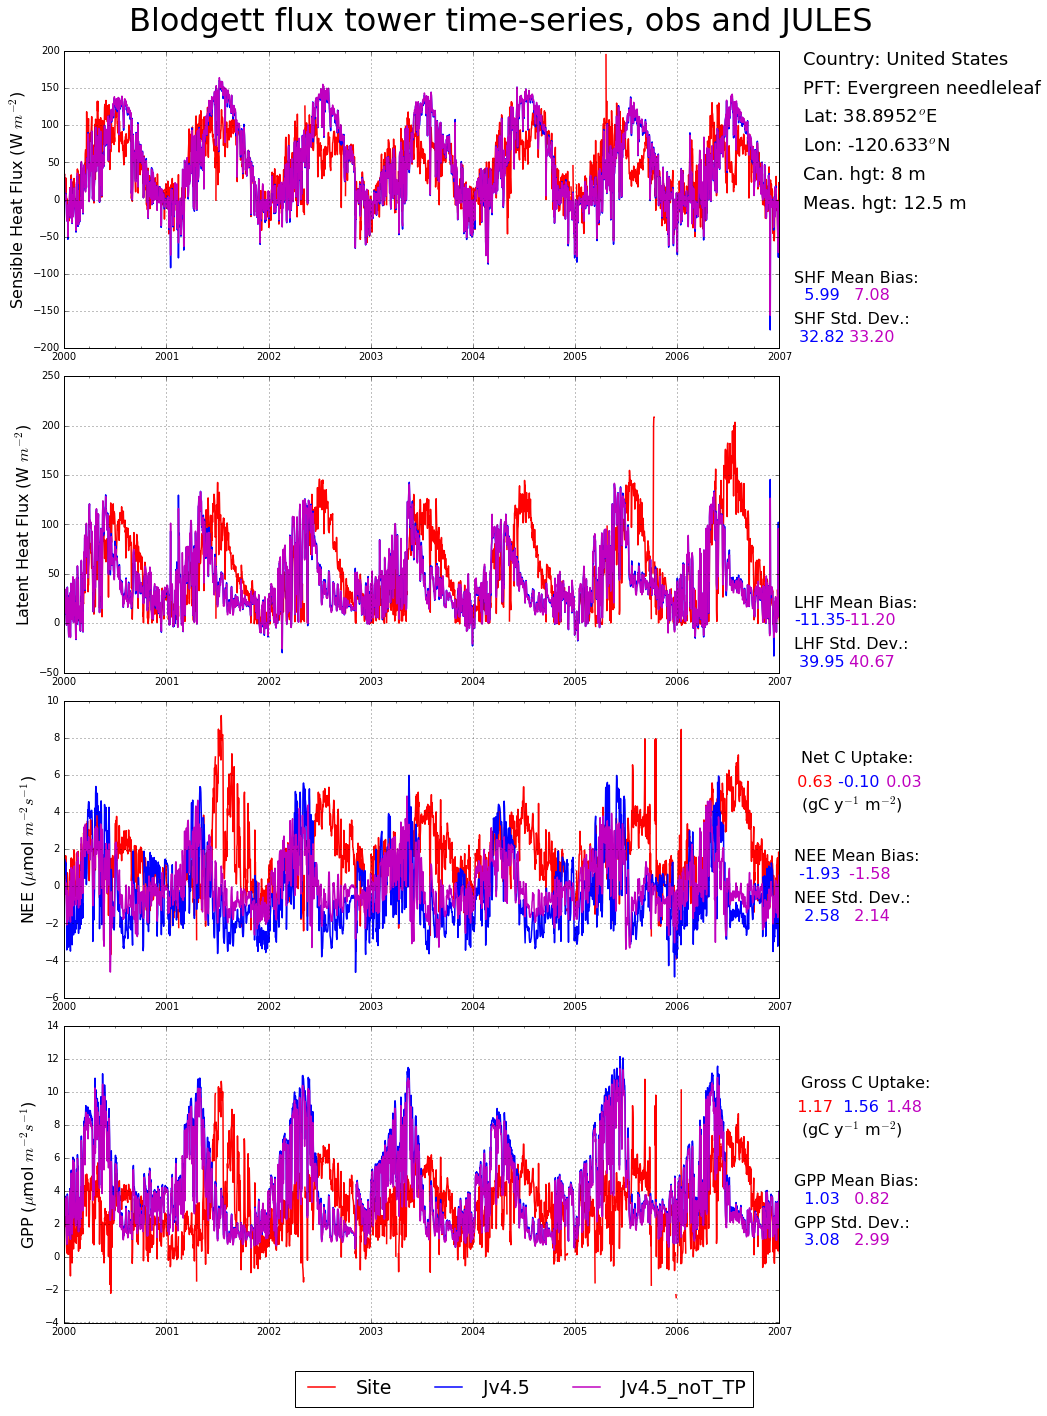

In [16]:

##########################################################
# Plot time-series of SHF, LHF, and NEE
FS=16
FIG,AXES = plt.subplots(nrows=4,ncols=1,figsize=(14,20))

AX = AXES[0]
SHF_panda.plot(lw=1.5,ax=AX,color=PS_colours,legend=False)
AX.text(1.02,0.22,"SHF Mean Bias: ",transform=AX.transAxes, fontsize=FS)
AX.text(1.02,0.08,"SHF Std. Dev.: ",transform=AX.transAxes, fontsize=FS)
for Jcnt in range(nJSOURCES):
    AX.text(1.02+(Jcnt*0.07),0.16,"%6.2f"%(SHF_meanbias[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
    AX.text(1.02+(Jcnt*0.07),0.02,"%6.2f"%(SHF_stddev[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
AX.set_ylabel('Sensible Heat Flux (W $m^{-2}$)', fontsize=FS)
AX.grid(True)

AX = AXES[1]
LHF_panda.plot(lw=1.5,ax=AX,color=PS_colours,legend=False)
AX.text(1.02,0.22,"LHF Mean Bias: ",transform=AX.transAxes, fontsize=FS)
AX.text(1.02,0.08,"LHF Std. Dev.: ",transform=AX.transAxes, fontsize=FS)
for Jcnt in range(nJSOURCES):
    AX.text(1.02+(Jcnt*0.07),0.16,"%6.2f"%(LHF_meanbias[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
    AX.text(1.02+(Jcnt*0.07),0.02,"%6.2f"%(LHF_stddev[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
AX.set_ylabel('Latent Heat Flux (W $m^{-2}$)', fontsize=FS)
handles,labels=AX.get_legend_handles_labels()
AX.grid(True)

AX = AXES[2]
NEE_panda.plot(lw=1.5,ax=AX,color=PS_colours,legend=False)
AX.text(1.02,0.46,"NEE Mean Bias: ",transform=AX.transAxes, fontsize=FS)
AX.text(1.02,0.32,"NEE Std. Dev.: ",transform=AX.transAxes, fontsize=FS)
for Jcnt in range(nJSOURCES):
    AX.text(1.02+(Jcnt*0.07),0.4,"%6.2f"%(NEE_meanbias[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
    AX.text(1.02+(Jcnt*0.07),0.26,"%6.2f"%(NEE_stddev[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
    AX.text(1.075+(Jcnt*0.06),0.71,"%6.2f"%(JULES_Net_Annual_Cuptake[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
AX.set_ylabel('NEE ($\mu$mol $m^{-2} s^{-1}$)',fontsize=FS)
AX.text(1.03,0.79,"Net C Uptake:",\
        transform=AX.transAxes, fontsize=FS)
AX.text(1.01,0.71,"%6.2f"%(SITE_Net_Annual_Cuptake),\
        transform=AX.transAxes, fontsize=FS, color=SITE_colour )
AX.text(1.03,0.63,"(gC y$^{-1}$ m$^{-2}$)",\
        transform=AX.transAxes, fontsize=FS)
AX.grid(True)

AX = AXES[3]
GPP_panda.plot(lw=1.5,ax=AX,color=PS_colours,legend=False)
AX.text(1.02,0.46,"GPP Mean Bias: ",transform=AX.transAxes, fontsize=FS)
AX.text(1.02,0.32,"GPP Std. Dev.: ",transform=AX.transAxes, fontsize=FS)
for Jcnt in range(nJSOURCES):
    AX.text(1.02+(Jcnt*0.07),0.4,"%6.2f"%(GPP_meanbias[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
    AX.text(1.02+(Jcnt*0.07),0.26,"%6.2f"%(GPP_stddev[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
    AX.text(1.075+(Jcnt*0.06),0.71,"%6.2f"%(JULES_Gross_Annual_Cuptake[Jcnt]), \
            transform=AX.transAxes, fontsize=FS, color=PS_colours[Jcnt+1] )
AX.set_ylabel('GPP ($\mu$mol $m^{-2} s^{-1}$)',fontsize=FS)
AX.text(1.03,0.79,"Gross C Uptake: ",\
        transform=AX.transAxes, fontsize=FS)
AX.text(1.01,0.71,"%6.2f"%(SITE_Gross_Annual_Cuptake),\
        transform=AX.transAxes, fontsize=FS, color=SITE_colour )
AX.text(1.03,0.63,"(gC y$^{-1}$ m$^{-2}$)",\
        transform=AX.transAxes, fontsize=FS)
AX.grid(True)

FIG.legend( handles,labels, loc=8, ncol=nJSOURCES+1, fontsize=FS+3)
FIG.tight_layout(rect=[0,0.05,0.8,0.96])
FIG.suptitle(site_name+' flux tower time-series, obs and JULES',\
             fontsize=FS*2)
FIG.text(0.8,0.94,'Country: '+site_country,fontsize=FS+2)
FIG.text(0.8,0.92,'PFT: '+site_vegtype,fontsize=FS+2)
FIG.text(0.8,0.9,'Lat: '+site_lat+'$^o$E',fontsize=FS+2)
FIG.text(0.8,0.88,'Lon: '+site_lon+'$^o$N',fontsize=FS+2)
FIG.text(0.8,0.86,'Can. hgt: '+site_canht+' m',fontsize=FS+2)
FIG.text(0.8,0.84,'Meas. hgt: '+site_measht+' m',fontsize=FS+2)


#FIG.savefig(site_plot_dir+site_name+'_Flux_Comparison_Time-Series.png', \
#            bbox_inches='tight')
  


In [17]:
#J_panda['smcl_bulk']


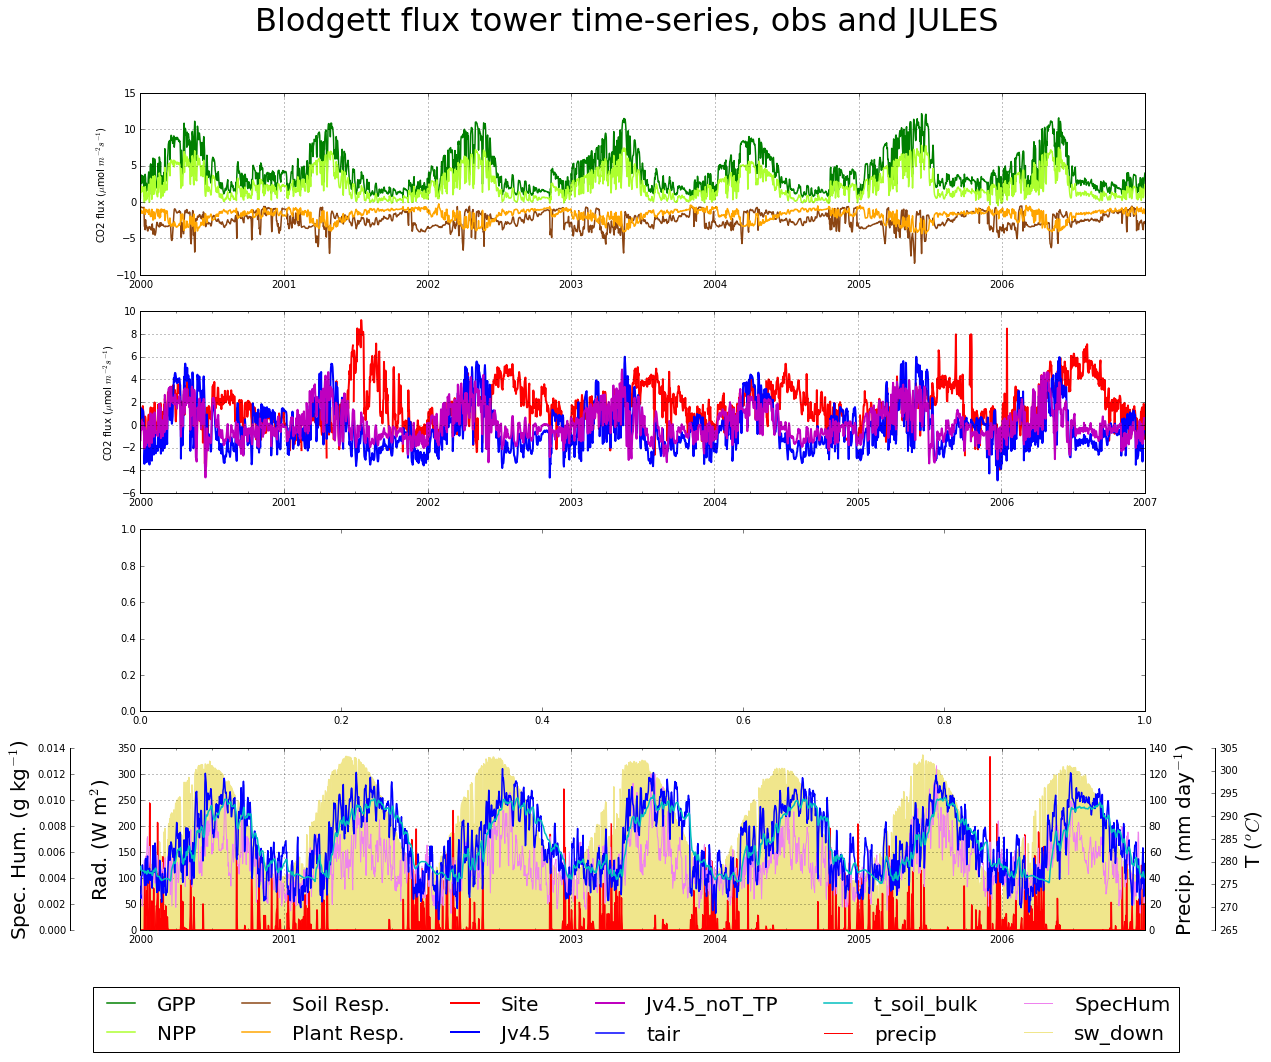

In [19]:
##########################################################
# Plot time-series breakdown of CO2 fluxes
Jcnt=0
J_panda=J_pandas[Jcnt]
FIG,AXES = plt.subplots(nrows=4,ncols=1,figsize=(18,15))

AX = AXES[0]
#print GPP_panda
Jname = J_names[Jcnt] 
AX.plot(GPP_panda.index,GPP_panda[Jname],lw=1.5,color='g',label='GPP') 
AX.plot(NPP_panda.index,NPP_panda[Jname],lw=1.5,color='greenyellow',label='NPP')
AX.plot(RESPS_panda.index,RESPS_panda[Jname]*-1.,lw=1.5,color='saddlebrown',label='Soil Resp.')
AX.plot(RESPP_panda.index,RESPP_panda[Jname]*-1.,lw=1.5,color='orange',label='Plant Resp.')
AX.grid(b=True)
AX.set_ylabel('CO2 flux ($\mu$mol $m^{-2} s^{-1}$)')
handles,labels=AX.get_legend_handles_labels()

AX=AXES[1]
NEE_panda.plot(lw=2,ax=AX,color=PS_colours,legend=False)
AX.set_ylabel('CO2 flux ($\mu$mol $m^{-2} s^{-1}$)')
handles2,labels2=AX.get_legend_handles_labels()
handles=handles+handles2
labels=labels+labels2
AX.grid(True)

#AX=AXES[2]
#AX.grid(True)
#roff_VARS=['runoff','SUBroff','SURFroff']
#roff_cols=['b','k','chocolate','lime']
#(J_panda[roff_VARS]*86400).plot(ax=AX,legend=False,lw=3,color=roff_cols)
#AX.set_label('Runoff (mm day$^{-1}$)')
#SM_AX=AX.twinx()
#handles2,labels2=AX.get_legend_handles_labels()
#handles+=handles2
#labels+=labels2
#J_panda['smcl_bulk'].plot(ax=SM_AX,color='darkgreen',legend=False,lw=3)
#SM_AX.set_ylabel('SM (kg m$^{-2}$)',fontsize=20)
#handles2,labels2=SM_AX.get_legend_handles_labels()
#handles+=handles2
#labels+=labels2


AX=AXES[3]
AX.grid(True)

T_AX=AX.twinx()
T_Vars=['tair','t_soil_bulk']
T_Cols=['b','c']#,'navy']
J_panda[T_Vars].plot(ax=T_AX,color=T_Cols,legend=False,lw=1.5)
T_AX.set_ylabel('T ($^{o}C$)',fontsize=20)
T_AX.spines['right'].set_position(('axes',1.07))
T_AX.set_frame_on(True)
T_AX.patch.set_visible(False)
for sp in T_AX.spines.values():
    sp.set_visible(False)
T_AX.spines['right'].set_visible(True)
T_AX.set_zorder(3)
handles2,labels2=T_AX.get_legend_handles_labels()
handles+=handles2
labels+=labels2

P_AX=AX.twinx()
(J_panda['precip']*86400.).plot.area(ax=P_AX,\
                                     color='r',legend=False)
P_AX.set_ylabel('Precip. (mm day$^{-1}$)',fontsize=20)
P_AX.yaxis.tick_right()
P_AX.yaxis.set_label_position('right')
handles2,labels2=P_AX.get_legend_handles_labels()
handles+=handles2
labels+=labels2

Q_AX=AX.twinx()
J_panda['SpecHum'].plot(ax=Q_AX,color='violet')   
Q_AX.yaxis.tick_left()
Q_AX.spines['left'].set_position(('axes',-.07))
Q_AX.set_frame_on(True)
Q_AX.patch.set_visible(False)
for sp in Q_AX.spines.values():
    sp.set_visible(True)
Q_AX.spines['right'].set_visible(True)
Q_AX.yaxis.set_label_position('left')
Q_AX.set_ylabel('Spec. Hum. (g kg$^{-1}$)',fontsize=20)
Q_AX.set_zorder(2)
handles2,labels2=Q_AX.get_legend_handles_labels()
handles+=handles2
labels+=labels2

R_AX=AX#.twinx()
J_panda['sw_down'].plot.area(ax=R_AX,color='khaki',legend=False)
#J_panda['smcl_bulk'].plot(ax=R_AX,color='darkgreen',legend=False,lw=3)
#R_AX.set_ylabel('Rad. (W m$^{2}$)/SM (kg m$^{-2}$',fontsize=20)
R_AX.set_ylabel('Rad. (W m$^{2}$)',fontsize=20)
R_AX.set_zorder(0)
R_AX.grid(True)
handles2,labels2=R_AX.get_legend_handles_labels()
handles+=handles2
labels+=labels2

FIG.legend( handles,labels, loc=8, ncol=6, fontsize=FS+4)
#FIG.tight_layout(rect=[0,0.05,0.96,0.96])
FIG.suptitle(site_name+' flux tower time-series, obs and JULES',\
             fontsize=FS*2)
FIG.savefig(site_plot_dir+site_name+'_CO2_Flux_Breakdown_Time-Series.png', \
            bbox_inches='tight')
       

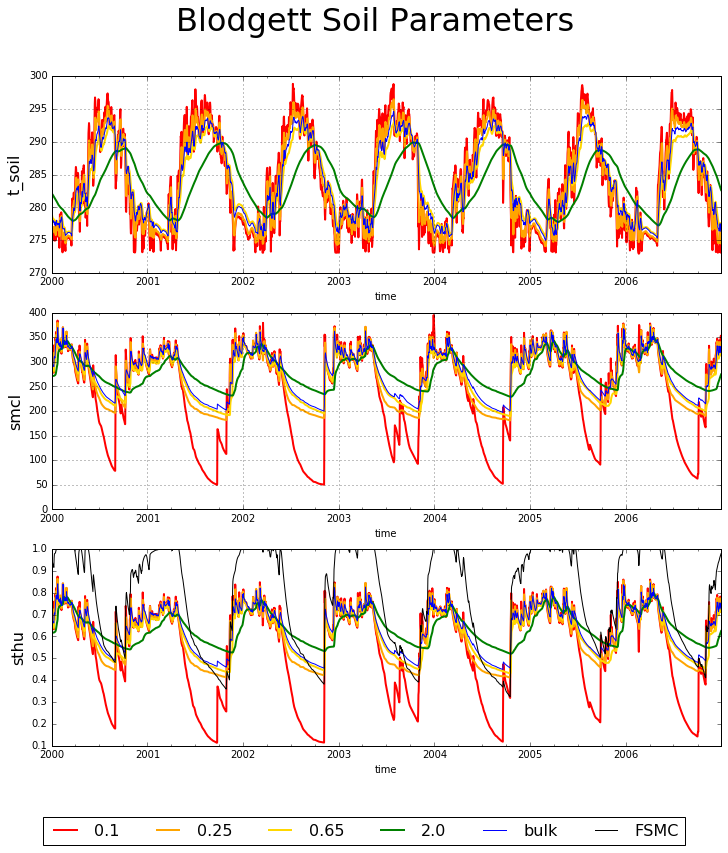

In [118]:
FS=16

Soil_Vars=['t_soil','smcl','sthu']
SD_cols=['r','orange','gold','green']
bulk_col='blue'
FIG,AXES=plt.subplots(nrows=3,ncols=1,figsize=(12,12))

for AX,VAR in zip(AXES,Soil_Vars):
    for SD,col in zip(J_soil_depths,SD_cols):
        J_soil_panda[VAR].xs(SD,level=1,axis=0).plot(ax=AX,label=str(SD),lw=2,c=col)
    J_panda[VAR+'_bulk'].plot(ax=AX,label='bulk',c=bulk_col)
    AX.set_ylabel(VAR,fontsize=FS)
    AX.grid(True)

J_panda['FSMC'].plot(ax=AX,color='k')

handles,labels=AX.get_legend_handles_labels()
FIG.legend(handles,labels,loc=8,ncol=6,fontsize=FS*1)
FIG.suptitle(site_name+' Soil Parameters',fontsize=FS*2)

FIG.savefig(site_plot_dir+site_name+'_Soil_Parameters_Time-Series.png', \
            bbox_inches='tight')


In [116]:
print(J_panda['runoff'].sum())
print(J_panda['precip'].sum())
print(J_panda['runoff'].sum()/J_panda['precip'].sum())

0.0769629
0.111748
0.688721


In [ ]:
J_panda['FSMC'].plot()



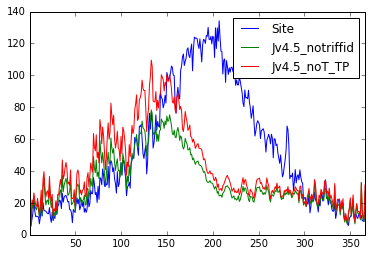

In [128]:
#Calculate Seaasonality pandas
# Latent Heat Flux
LHF_season_panda=LHF_panda.dropna(0).copy()
LHF_season_panda = LHF_season_panda.groupby(LHF_season_panda.index.dayofyear).mean()
#LHF_season_panda.plot()
# Sensible Heat Flux
SHF_season_panda=SHF_panda.dropna(0).copy()
SHF_season_panda=SHF_season_panda.groupby(SHF_season_panda.index.dayofyear).mean()

# Net Ecosystem Exchange
NEE_season_panda=NEE_panda.dropna(0).copy()
NEE_season_panda=NEE_season_panda.groupby(NEE_season_panda.index.dayofyear).mean()
# Gross Primary Productivity
GPP_season_panda=GPP_panda.dropna(0).copy()
GPP_season_panda=GPP_season_panda.groupby(GPP_season_panda.index.dayofyear).mean()
# Total Ecosystem Respiration
TER_season_panda=TER_panda.dropna(0).copy()
TER_season_panda=TER_season_panda.groupby(TER_season_panda.index.dayofyear).mean()


array([  1,   2,   3, ..., 362, 363, 364], dtype=int32)